# The Indiana Training Program in Public and Population Health Informatics
## EXERCISE 4 
### Examine the Association Between Glycemic Control (Hba1c) and Body Mass Index (BMI)

*Competencies addressed*  
 
 1. Apply data merging/linking and reshaping methods (I.1.3)
 2. Transformation of raw data to formats more suitable for downstream use cases (I.1.2)
 3. Demonstrate the ability to describe data (find means, standard deviations, outliers, evaluate correlations etc.) (II.1.2)
 4. Acquire skills related to visualize data to discover patterns (II.1.3)
 5. Apply inferential statistical methods (II.2)


*Learning objectives*  
 At the end of this module the student will be able to do the following:
4. Perform basic transformation of the dataset in multiple ways
5. Create derived variables using several vector transformations
6. Create visualizations to describe the data


In this exercise, we will purge the Hba1c test results from the clinical_vars.csv data file and combine it with the BMI information we previously enhanced. We will add race and gender information and check how Hba1c changes for these groups. Finally, we will create a linear model for Hba1c as outcome and BMI, gender and race as independent variables. 

### Loading clinical_vars.csv
Before we start working in R, we need to set the working directory. We will then our check folder contents and load the clinical variables data file using the `fread` function, which is faster. 

In [1]:
getwd() # Check the working directory.
setwd("/N/dc2/projects/T15/Sample") # Set the working folder. Change this path to the location where YOUR files are.
# If you haven't already done so, install the data.table package using the code below.
install.packages("data.table") 
library(data.table)
clinical <- fread("clinical_vars.csv", sep = ",", header= TRUE)
head(clinical, n=5 )

[1] "/N/dc2/projects/T15/Sample"

STUDYID,OBS,TYPE,OBSVALUE,CODED_CODE,CODE_NAME,DAYS_VIS_INDEX
16,Acetaminophen,Medications,3783,,,-392
16,Acetamnphn W/Cod,Medications,12,,,-392
16,BP Dias Sitting,Phenotypes,69,,,-392
16,BP Sys Sitting,Phenotypes,158,,,-392
16,Clinic Site,Other,NA,3636,MED CL,-392


### Creating a list (table) of the OBS
To find the test for Hba1c, we will create a list of the observations from the clinical data.

In [2]:
obs_data <- as.data.frame(table(clinical$OBS))
# Let's check the table using the head function.
head(obs_data)

Var1,Freq
# Cells Counted in Diff,19017
17 OH Progest SerPl Qn,100
A 1 Antitrypsin SerPl Qn,910
A1 Glob Ser Qn Elp,5243
A2 Glob Ser Qn Elp,5267
ABDOMINAL PAIN PAST MONTH,15


### Filtering the list for Hba1c tests
In the list we created (obs_data), we will search for the keywords `a1c` and `glycate` to find the tests we want.<br>
We will use the `str_detect` function from the `stringr` package. 

In [3]:
library(stringr) 
# Search for "a1c" and "glycated" within the obs_data file.
name_list <- obs_data[str_detect(obs_data$Var1, regex('a1c|glycated', ignore_case=TRUE)),]
name_list <- name_list[ order(-name_list$Freq), ] # Order by frequency (large to small).
colnames(name_list)[1] <- "OBS"
as.data.frame(name_list)


,OBS,Freq
978,Hgb A1C Bld Qn HPLC,44342
974,Hgb A1C Bld Qn (Meth),19145
975,Hgb A1C Bld Qn (POC),17119
980,Hgb A1c Bld Qn IA,5302
825,Glycated Hb-Total (Hplc),1956
977,Hgb A1C Bld Qn Calc,1940
915,Hb A1C Calculated,1930
826,Glycated Hgb %,1546
976,Hgb A1C Bld Qn (POC) QC Checked,338
993,HgbA1C % Ser EIA,300


### Extracting rows that has the OBS
We will use the dplyr package and the `%in%` function to match our list file (name_list). <br>
To do that, first we need to turn the name_list file class to "character". 

In [4]:
class(name_list$OBS)
name_list$OBS <- as.character(name_list$OBS)
name_list$OBS

[1] "factor"

[1] "Hgb A1C Bld Qn HPLC"             "Hgb A1C Bld Qn (Meth)"          
 [3] "Hgb A1C Bld Qn (POC)"            "Hgb A1c Bld Qn IA"              
 [5] "Glycated Hb-Total (Hplc)"        "Hgb A1C Bld Qn Calc"            
 [7] "Hb A1C Calculated"               "Glycated Hgb %"                 
 [9] "Hgb A1C Bld Qn (POC) QC Checked" "HgbA1C % Ser EIA"               
[11] "Hgb A1C+Est Av Gluc SerPl Panel"

### Using `filter` with pipe (`%>%`) creates the subset `A1C`
We will also choose the columns to keep using the `select` function with pipe (`%>%`). 

In [5]:
# If you have not already done so, install the Tidyverse package.
install.packages("tidyverse")
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
<U+221A> ggplot2 3.0.0     <U+221A> readr   1.1.1
<U+221A> tibble  1.4.2     <U+221A> purrr   0.2.5
<U+221A> tidyr   0.8.1     <U+221A> dplyr   0.7.6
<U+221A> ggplot2 3.0.0     <U+221A> forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()


In [6]:
# Filter the clinical variables data by A1C OBS names .
A1C <- clinical %>% filter(OBS %in% c(name_list$OBS)) %>% select(c("STUDYID","DAYS_VIS_INDEX", "OBS","OBSVALUE"))

### Here is the data set with A1C tests: 
Let's check the A1C file created and see the distribution of OBSVALUE. 

STUDYID,DAYS_VIS_INDEX,OBS,OBSVALUE
103,401,Glycated Hgb %,8.1
103,715,Glycated Hb-Total (Hplc),6.5
103,715,Hb A1C Calculated,5.9
103,1407,Glycated Hb-Total (Hplc),6.0
103,1407,Hb A1C Calculated,5.5
103,1731,Glycated Hb-Total (Hplc),7.0


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   6.000   6.700   7.158   7.600 783.000     355 

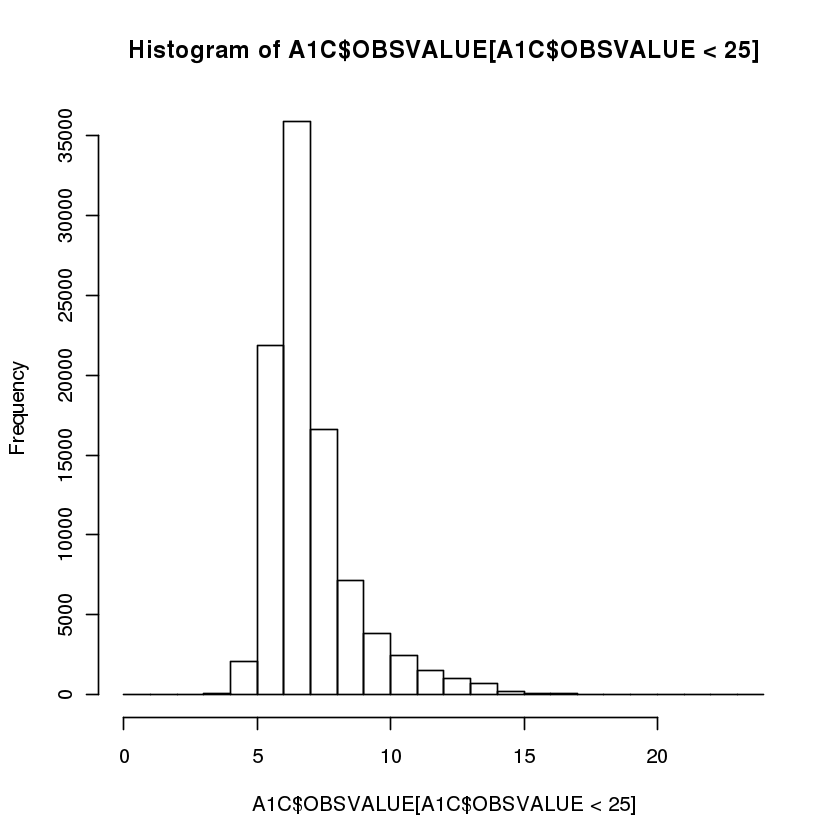

In [7]:
# Check the A1C file and A1C test values.
head(A1C)
hist(A1C$OBSVALUE[A1C$OBSVALUE<25])
summary(A1C$OBSVALUE)

### Merging in the race, age, and gender data
Now that we have created our new HbA1c file, we will need to add race, gender, and age at observation to do the group comparisons. We will add INDEX_AGE, GENDER, and RACE3 from the processed patient data file from Ex.1 <br>

The `merge` function, using STUDYID as the reference, is suitable for our needs. Please note that this is a left join where we keep all the A1C observations.

In [8]:
# Join age at index, race3, and gender from the patients data file with the A1C file. Use STUDYID to merge.
load(file = "patients.RDATA")
A1C <- merge(x = A1C, y = patients[,c("STUDYID", "GENDER", "RACE3", "INDEX_AGE")], 
             by = "STUDYID", all.x= TRUE) 
head(A1C)
rm (patients)
rm(obs_data, name_list, clinical)

STUDYID,DAYS_VIS_INDEX,OBS,OBSVALUE,GENDER,RACE3,INDEX_AGE
103,401,Glycated Hgb %,8.1,M,Black,71
103,715,Glycated Hb-Total (Hplc),6.5,M,Black,71
103,715,Hb A1C Calculated,5.9,M,Black,71
103,1407,Glycated Hb-Total (Hplc),6.0,M,Black,71
103,1407,Hb A1C Calculated,5.5,M,Black,71
103,1731,Glycated Hb-Total (Hplc),7.0,M,Black,71


### Calculating age at Hba1c tests
We will use the `mutate` function to calculate the age at observation with the use of the variables INDEX_AGE and DAY_VIS_INDEX.<br>
We will drop these columns and reorder them using the pipe (`%>%`) and `select` function. 

In [9]:
A1C <- A1C %>% 
  mutate(AGE = INDEX_AGE + DAYS_VIS_INDEX/365.25) %>%
  select(c("STUDYID", "GENDER", "RACE3", "AGE","OBS", "OBSVALUE"))
A1C$OBS <- "A1C"
head(A1C)


STUDYID,GENDER,RACE3,AGE,OBS,OBSVALUE
103,M,Black,72.09788,A1C,8.1
103,M,Black,72.95756,A1C,6.5
103,M,Black,72.95756,A1C,5.9
103,M,Black,74.85216,A1C,6.0
103,M,Black,74.85216,A1C,5.5
103,M,Black,75.73922,A1C,7.0


## Group comparisons
Now that we have the final dataset, we can compare HbA1c values by race, gender, and the age at observation.

### Age distribution by gender


    F     M 
50729 43195 

$F
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  8.237  51.070  61.000  60.280  70.690  95.200 

$M
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.12   51.57   61.10   60.63   70.20   96.27 


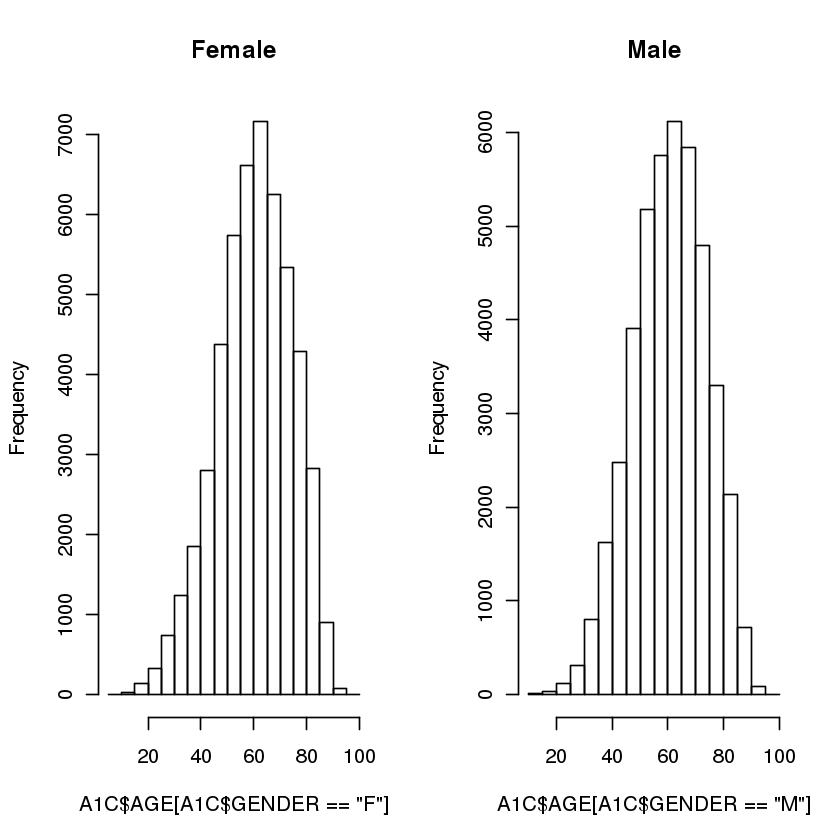

In [10]:
table(A1C$GENDER)
par(mfrow=c(1,2)) # prints 4 figures in one page
hist(A1C$AGE[A1C$GENDER == "F"], main= "Female")
hist(A1C$AGE[A1C$GENDER == "M"], main= "Male")
par(mfrow=c(1,1)) #reverst back to 1 figure for 1 page
tapply(A1C$AGE, A1C$GENDER, summary)

### Age distribution by race

$Black
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  8.237  48.510  57.490  57.380  66.740  96.270 

$Other
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.11   46.90   56.82   56.38   66.28   91.24 

$Unknown
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  16.46   46.54   58.00   57.39   68.72   88.09 

$White
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8.62   53.07   62.73   61.93   71.71   95.65 


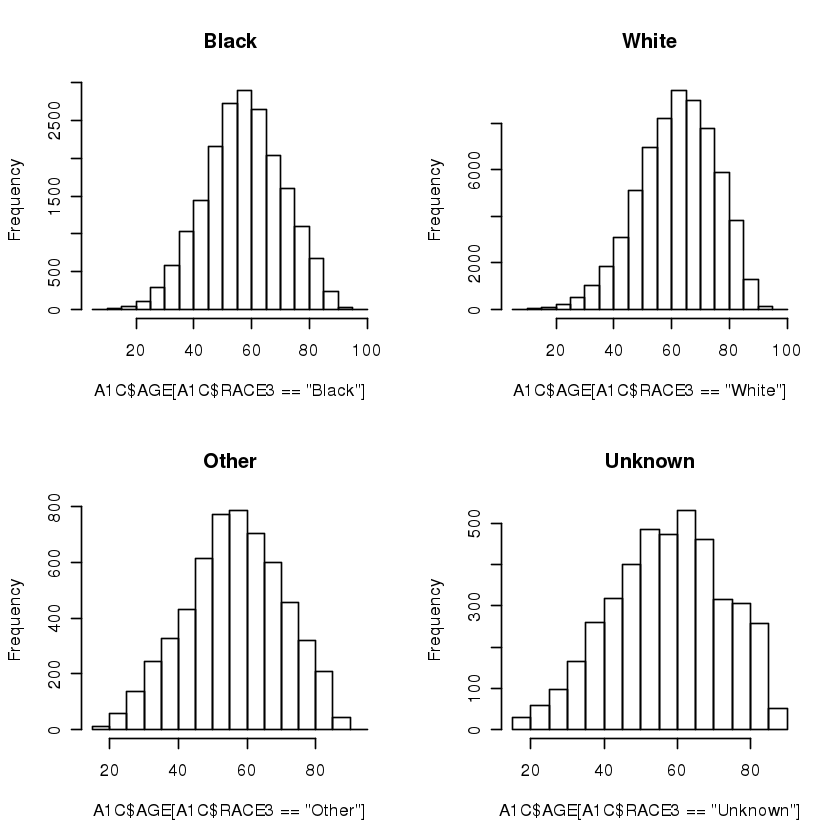

In [11]:
par(mfrow=c(2,2)) # prints 4 figures in one page
hist(A1C$AGE[A1C$RACE3 == "Black"], main= "Black")
hist(A1C$AGE[A1C$RACE3 == "White"], main= "White")
hist(A1C$AGE[A1C$RACE3 == "Other"], main= "Other")
hist(A1C$AGE[A1C$RACE3 == "Unknown"], main= "Unknown")
par(mfrow=c(1,1)) #reverst back to 1 figure for 1 page

tapply(A1C$AGE, A1C$RACE3, summary)

### Explore HbA1c values by race using a boxplot

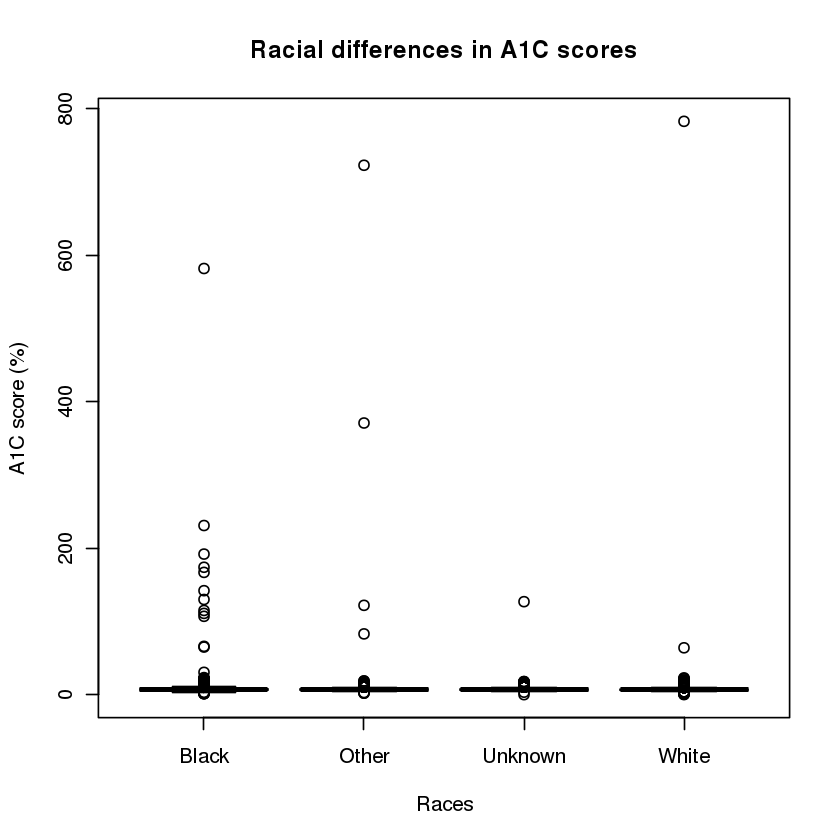

In [12]:
# Boxplot for RACE3 & A1C values
boxplot(OBSVALUE~RACE3, data=A1C, main="Racial differences in A1C scores", 
        xlab="Races", ylab="A1C score (%)")

### Remove extreme HbA1c values
In real life, the HbA1c values rarely go below 4% or above 18%. We will limit the HbA1c values in our file with these ranges.<br>
*Notice the <b>lower</b> HbA1c mean value for the White race. What do you think this could mean?

$Black
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.000   6.100   6.700   7.346   7.900  18.000 

$Other
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.300   6.200   6.900   7.316   7.900  16.300 

$Unknown
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.100   6.100   6.800   7.285   7.800  17.900 

$White
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  4.000   6.000   6.700   7.009   7.500  18.000 


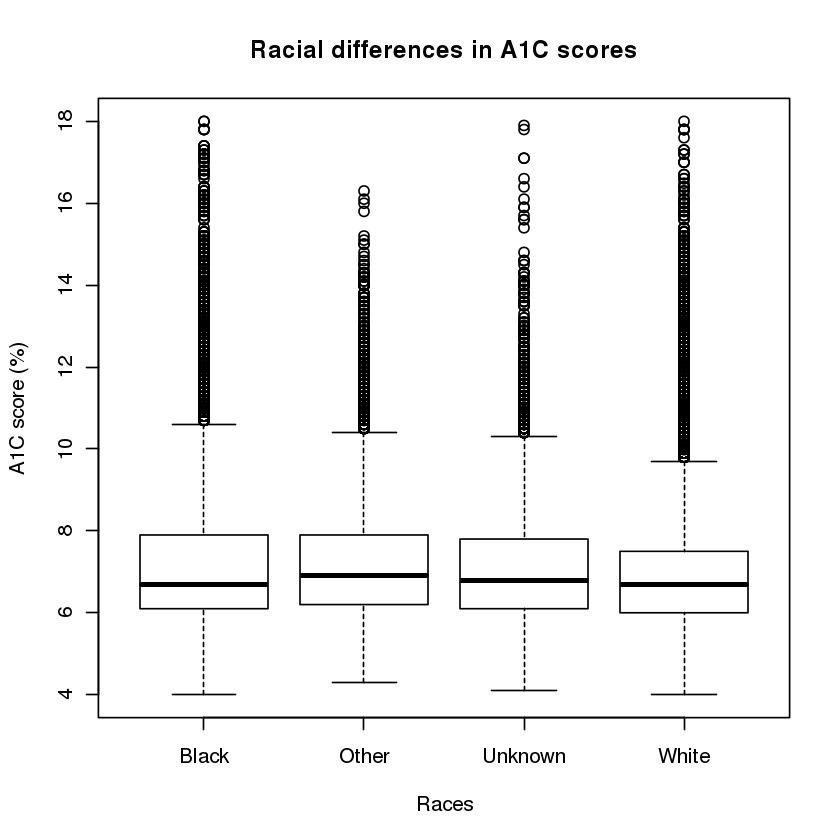

In [13]:
A1C <- A1C %>% filter (OBSVALUE >=4, OBSVALUE <= 18 )

boxplot(OBSVALUE~RACE3, data=A1C, main="Racial differences in A1C scores", 
        xlab="Races", ylab="A1C score (%)")

tapply(A1C$OBSVALUE, A1C$RACE3, summary)

### Create a scatter plot of  HbA1c values over age

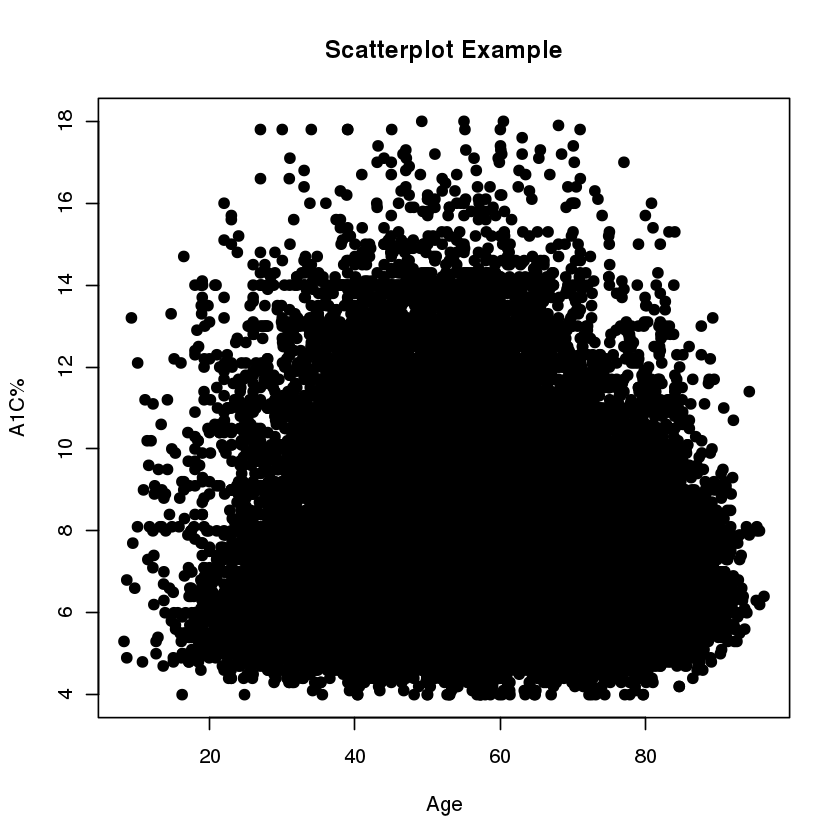

In [14]:
plot(A1C$AGE, A1C$OBSVALUE, main="Scatterplot Example", 
     xlab="Age", ylab="A1C%", pch=19)


### Try using hexbin to plot HbA1c values over age.
Hexbin is often a better way to display data when scatter plots are too crowded to be meaningful.

In [15]:
# If you haven't done so already, install the Hexbin package.
install.packages("hexbin")
library(hexbin)

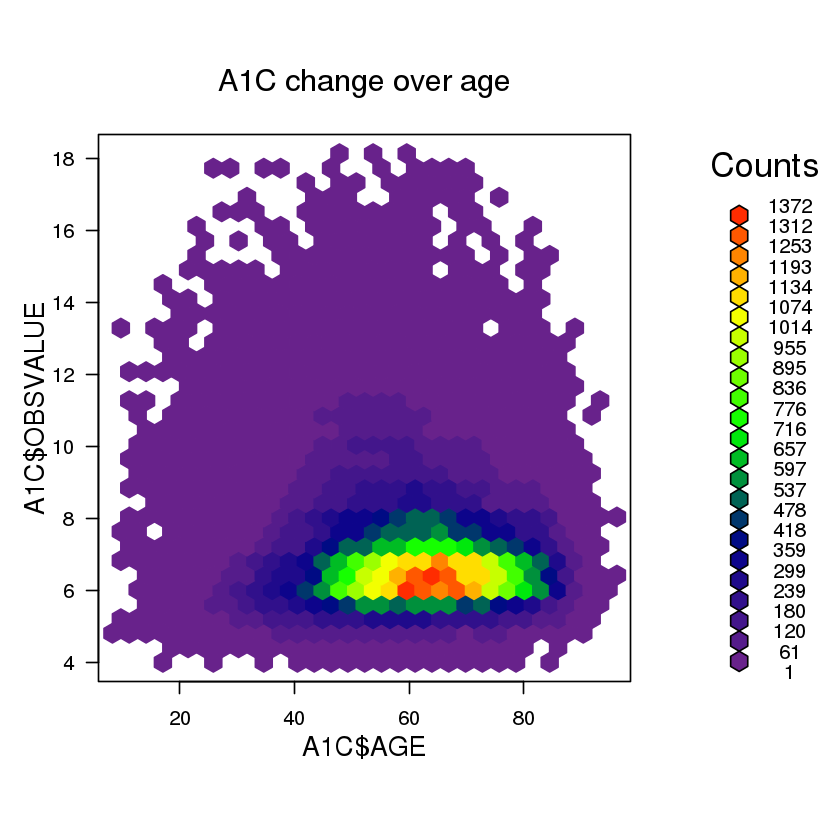

In [16]:
cols <- colorRampPalette(c("darkorchid4","darkblue","green","yellow", "red") )
hbin <- hexbin(A1C$AGE, A1C$OBSVALUE)
plot(hbin, main="A1C change over age", colorcut = seq(0,1,length.out=24),
     colramp = function(n) cols(24) ) # , legend = 0 )

rm(hbin)

### Let's add BMI data to the A1C data
Below, we will work on the enhanced BMI data file that we created in Ex 3.2. <br>
To add the rows of the two files to each other, the column names and order must match.<br>
We will edit the dataset for our purposes and make it ready for the A1C file.

In [17]:
# Load the wt_ht_final.RDATA from the end of Ex 3.2.
load(file = "wt_ht_final.RDATA")
head(wt_ht_final)
wt_ht_final$OBS <- "BMI"
names(wt_ht_final)[9] <- "OBSVALUE"
head(wt_ht_final)

STUDYID,DAYS_VIS_INDEX,BMI,weight,n,ht_mean,INDEX_AGE,AGE,BMI_calc
16,-392,NA,65.3184,14,147.32,76,74.92676,30.09623
16,-382,NA,67.1328,14,147.32,76,74.95414,30.93224
16,-266,NA,65.7720,14,147.32,76,75.27173,30.30523
16,-245,NA,68.9472,14,147.32,76,75.32923,31.76824
16,-200,NA,65.3184,14,147.32,76,75.45243,30.09623
16,-154,NA,65.7720,14,147.32,76,75.57837,30.30523


STUDYID,DAYS_VIS_INDEX,BMI,weight,n,ht_mean,INDEX_AGE,AGE,OBSVALUE,OBS
16,-392,NA,65.3184,14,147.32,76,74.92676,30.09623,BMI
16,-382,NA,67.1328,14,147.32,76,74.95414,30.93224,BMI
16,-266,NA,65.7720,14,147.32,76,75.27173,30.30523,BMI
16,-245,NA,68.9472,14,147.32,76,75.32923,31.76824,BMI
16,-200,NA,65.3184,14,147.32,76,75.45243,30.09623,BMI
16,-154,NA,65.7720,14,147.32,76,75.57837,30.30523,BMI


### Adding gender and race to the BMI data
We will be using the patients data file from Ex 1 for this purpose. Add in the variables STUDYID, GENDER, and RACE3 using the STUDYID variable to merge.

In [18]:
load(file = "patients.RDATA")

wt_ht_final <- merge(x = wt_ht_final, y = patients[,c("STUDYID", "GENDER", "RACE3")], 
                     by = "STUDYID", all.x= TRUE) 
head(wt_ht_final)
rm(patients)

STUDYID,DAYS_VIS_INDEX,BMI,weight,n,ht_mean,INDEX_AGE,AGE,OBSVALUE,OBS,GENDER,RACE3
16,-392,NA,65.3184,14,147.32,76,74.92676,30.09623,BMI,F,Black
16,-382,NA,67.1328,14,147.32,76,74.95414,30.93224,BMI,F,Black
16,-266,NA,65.7720,14,147.32,76,75.27173,30.30523,BMI,F,Black
16,-245,NA,68.9472,14,147.32,76,75.32923,31.76824,BMI,F,Black
16,-200,NA,65.3184,14,147.32,76,75.45243,30.09623,BMI,F,Black
16,-154,NA,65.7720,14,147.32,76,75.57837,30.30523,BMI,F,Black


### Tidying up the data 
Matching column order with the A1C data will help when joining the datasets. 

In [19]:
BMI <- wt_ht_final %>% select(c("STUDYID", "GENDER", "RACE3", "AGE", "OBS","OBSVALUE"))
names(BMI)
names(A1C)

rm(wt_ht_final)

[1] "STUDYID"  "GENDER"   "RACE3"    "AGE"      "OBS"      "OBSVALUE"

[1] "STUDYID"  "GENDER"   "RACE3"    "AGE"      "OBS"      "OBSVALUE"

### Join the two datasets together
Create the file A1C_BMI by joining the A1C file with the BMI file. 

In [20]:
A1C_BMI <- rbind(A1C, BMI)
head(A1C_BMI)

cat("unique Patient count with A1C measurements:",length(unique(A1C$STUDYID)),sep="\n");

cat("unique Patient count with BMI measurements: ",length(unique(BMI$STUDYID)),sep="\n");

cat("unique Patient count of the two groups combined: ",length(unique(A1C_BMI$STUDYID)),sep="\n");

STUDYID,GENDER,RACE3,AGE,OBS,OBSVALUE
103,M,Black,72.09788,A1C,8.1
103,M,Black,72.95756,A1C,6.5
103,M,Black,72.95756,A1C,5.9
103,M,Black,74.85216,A1C,6.0
103,M,Black,74.85216,A1C,5.5
103,M,Black,75.73922,A1C,7.0


unique Patient count with A1C measurements:
20008
unique Patient count with BMI measurements: 
9079
unique Patient count of the two groups combined: 
22946



### Let's order the rows by STUDYID, AGE, OBS, and OBSVALUE


In [21]:
A1C_BMI <- A1C_BMI[order(A1C_BMI$STUDYID, A1C_BMI$AGE, A1C_BMI$OBS, A1C_BMI$OBSVALUE),]
head(A1C_BMI)

,STUDYID,GENDER,RACE3,AGE,OBS,OBSVALUE
93466,16,F,Black,74.92676,BMI,30.09623
93467,16,F,Black,74.95414,BMI,30.93224
93468,16,F,Black,75.27173,BMI,30.30523
93469,16,F,Black,75.32923,BMI,31.76824
93470,16,F,Black,75.45243,BMI,30.09623
93471,16,F,Black,75.57837,BMI,30.30523


### Let's remove rows where OBSVALUE is NA or NAN

In [22]:
length(unique(A1C_BMI$STUDYID))
dim(A1C_BMI)

length(A1C_BMI$OBSVALUE[is.na(A1C_BMI$OBSVALUE)])
length(A1C_BMI$OBSVALUE[is.nan(A1C_BMI$OBSVALUE)])

# The is.na function also removes NAN values.
A1C_BMI <- A1C_BMI %>% filter(!is.na(OBSVALUE)) #, !is.nan(OBSVALUE))

length(unique(A1C_BMI$STUDYID))
dim(A1C_BMI)

[1] 22946

[1] 176357      6

[1] 19948

[1] 4401

[1] 21786

[1] 156409      6

### Linear regression model: A1C ~ Gender+Race+BMI
Diabetes goes though stages as it progresses with a patient's age. Therefore, we will restrict our observations to one age period. <br> 
We will focus on the 50-60 years old age group and filter A1C_BMI data by limiting the age at observation variable values to the 50-60 interval. 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  50.00   52.62   55.08   55.09   57.64   60.00 

[1] 38133     6

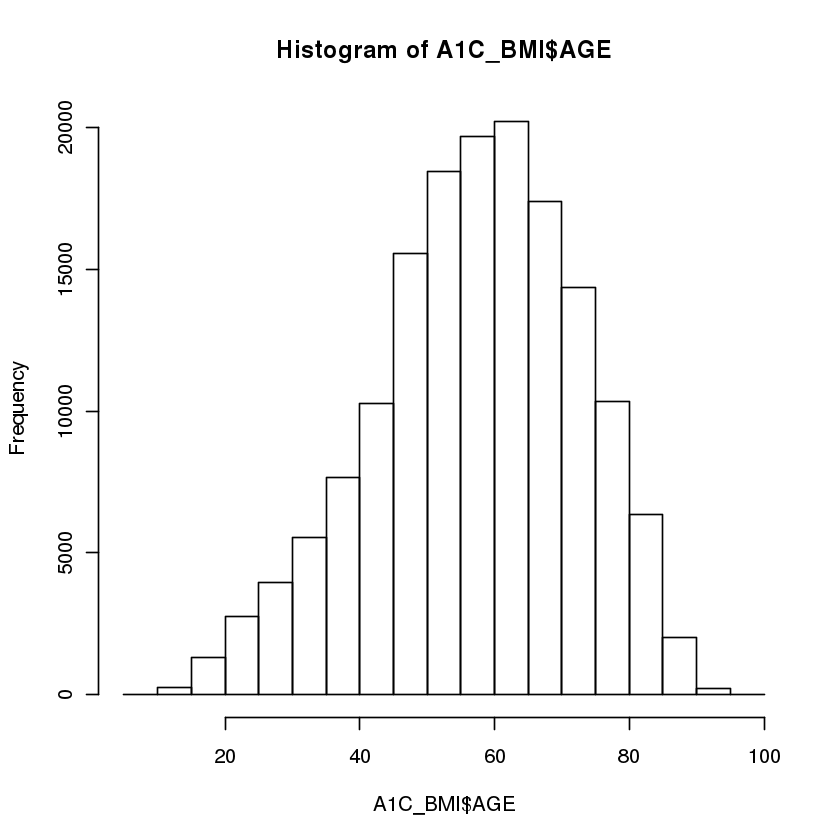

In [23]:
# Restrict the data to ages 50-59.99 using the filter function.
hist(A1C_BMI$AGE)
AB50 <- A1C_BMI %>% filter( 50<=AGE, AGE <60)
summary(AB50$AGE)
dim(AB50)

### Calculate the mean values for A1C and BMI and transform the dataset to wide
Using the `group_by` function from the dplyr package, we will calculate the mean A1C and BMI values for each patient. <br>
We will then transform the dataset to wide to prepare for analysis.  

In [24]:
AB50mean <- AB50 %>% group_by(STUDYID, GENDER, RACE3, OBS) %>% 
                        summarize(OBSmean= mean(OBSVALUE, na.rm=TRUE))
head(AB50mean)

AB50mean <- spread(AB50mean, OBS, OBSmean)
head(AB50mean)

STUDYID,GENDER,RACE3,OBS,OBSmean
179,M,Black,BMI,27.476376
188,M,Black,A1C,6.166667
239,F,Black,A1C,6.845000
239,F,Black,BMI,40.413829
251,F,Black,BMI,30.634410
269,F,White,A1C,12.240000


STUDYID,GENDER,RACE3,A1C,BMI
179,M,Black,NA,27.47638
188,M,Black,6.166667,NA
239,F,Black,6.845000,40.41383
251,F,Black,NA,30.63441
269,F,White,12.240000,45.19331
340,F,Black,NA,45.48744


### Scatterplot for A1C and BMI
 Let's check the correlation between A1C and BMI and visualize it. 

[1] 0.002803905

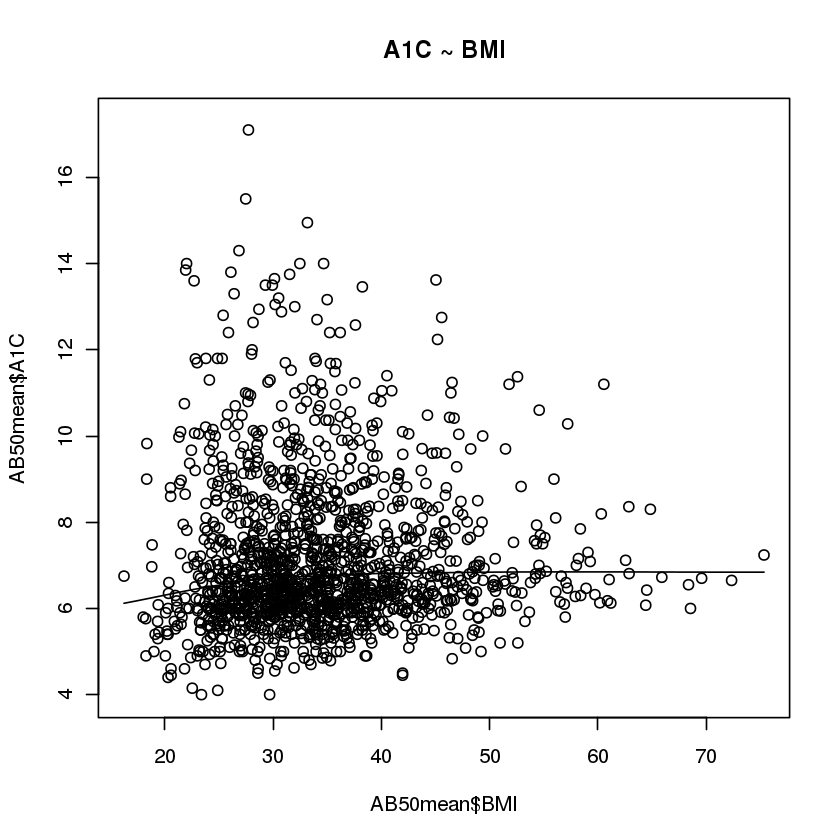

In [25]:
scatter.smooth(x=AB50mean$BMI, y=AB50mean$A1C, main="A1C ~ BMI")  # Create a scatterplot.
cor(AB50mean$BMI, AB50mean$A1C,  use = "pairwise.complete.obs")


### Let's build our linear model
For categorial variables such as race and gender, we check the reference level first. <br>
Reference levels are the first field in the table. 

In [26]:
attributes(AB50mean$GENDER)

attributes(AB50mean$RACE3)

$levels
[1] "F" "M"

$class
[1] "factor"

$levels
[1] "Black"   "Other"   "Unknown" "White"  

$class
[1] "factor"

### Changes the reference levels
The reference level for gender is currently set to be females and the reference level for race is Black. Let's change the reference level for gender to be males.

In [27]:
AB50mean$GENDER <- relevel(AB50mean$GENDER, ref="M")
table(AB50mean$GENDER)


   M    F 
3393 3472 

### Create the linear model
We will be fitting a linear model between A1C and BMI and will also take into account the gender and race. Statistics are called with the `summary` function, which gives the coefficients as well as the p-values. <br>

We see that the race values "Unknown" and "White" are significantly different in the A1C response model when gender and BMI are taken into account in the 50-year age group. <br>

Changing the model, such as adding or removing variables or using a different age group, may modify this outcome. Rather than trying out different combinations, it is considered good practice to select these model details using biological background information.

In [28]:
fit <- lm(A1C ~ GENDER+RACE3+BMI, data=AB50mean)
summary(fit)

# Use the codes below to examine various model fit plots.
# par(mfrow=c(2,2))
# plot(fit) 
# par(mfrow=c(1,1))


Call:
lm(formula = A1C ~ GENDER + RACE3 + BMI, data = AB50mean)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3724 -1.0995 -0.5187  0.6740  9.8153 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   7.290938   0.200066  36.443  < 2e-16 ***
GENDERF      -0.102808   0.093864  -1.095  0.27357    
RACE3Other    0.158317   0.190024   0.833  0.40490    
RACE3Unknown  0.879949   0.315722   2.787  0.00539 ** 
RACE3White   -0.416011   0.096715  -4.301 1.81e-05 ***
BMI           0.003482   0.005460   0.638  0.52373    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.736 on 1450 degrees of freedom
  (5409 observations deleted due to missingness)
Multiple R-squared:  0.02419,	Adjusted R-squared:  0.02082 
F-statistic: 7.188 on 5 and 1450 DF,  p-value: 1.176e-06


== END OF EX 4 ==